**Plant disease detection (Plant name and disease name)**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7488801333198973225
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5746845208684739554
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1624926662538819601
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11330115994
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4205732552721608641
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


**Getting data**


Paths of images and there corresponding labels are stored in lists. List of image paths is later used to load images in batches.

In [0]:
import os
os.getcwd()

'/content'

In [0]:
os.chdir(r"drive/My Drive/plantvillage/color")


In [0]:
data_path=os.getcwd()

In [0]:
label_counter=0
img_name_list=[]
labels=[]
label_map_dic={}
count=0

for filename in os.listdir(data_path):
    foldername=filename.strip()
    for imgname in os.listdir(data_path+"/"+filename):
        imagepath=data_path+"/"+filename+"/"+imgname
        img_name_list.append(imagepath)
        labels.append(label_counter)
        count+=1
    if label_counter not in label_map_dic:
        label_map_dic[foldername]=label_counter
    label_counter+=1
    print(str(count) + " " + foldername)
        

1645 Apple___healthy
2807 Corn_(maize)___healthy
4309 Blueberry___healthy
5361 Cherry_(including_sour)___Powdery_mildew
5636 Apple___Cedar_apple_rust
6490 Cherry_(including_sour)___healthy
7682 Corn_(maize)___Common_rust_
8312 Apple___Apple_scab
8825 Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
9446 Apple___Black_rot
10522 Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
10882 Peach___healthy
11305 Grape___healthy
12290 Corn_(maize)___Northern_Leaf_Blight
13470 Grape___Black_rot
18997 Orange___Haunglongbing_(Citrus_greening)
21294 Peach___Bacterial_spot
22291 Pepper,_bell___Bacterial_spot
23769 Pepper,_bell___healthy
25152 Grape___Esca_(Black_Measles)
26162 Potato___Late_blight
27271 Strawberry___Leaf_scorch
32361 Soybean___healthy
32817 Strawberry___healthy
34652 Squash___Powdery_mildew
35652 Tomato___Early_blight
35804 Potato___healthy
36175 Raspberry___healthy
37183 Potato___Early_blight
39310 Tomato___Bacterial_spot
41219 Tomato___Late_blight
42623 Tomato___Target_Spot
42996 Tomato

In [0]:
print(len(img_name_list))
print(len(labels))

54362
54362


Using TensorFlow backend.


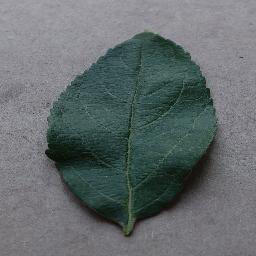

In [0]:
from keras.preprocessing import image
image.load_img(img_name_list[7])

**Randomizing**

The lists are randomized so that we have equal distribution of all classes in test set and training set

In [0]:
import random
a=list(range(len(labels)))
random.shuffle(a)
img_name_list=[img_name_list[i] for i in a ]
labels=[labels[i] for i in a]

**Function get_batch()**

This function helps to retrieve a single batch of data of defined batch size. Global index (current_index) is increased after taking every batch so that every time next batch is retrieved

In [0]:

import numpy as np
from keras.utils import to_categorical
def get_batch():
    index=0
    global current_index
    B=np.zeros(shape=(64,224,224,3))
    L=np.zeros(64)
    while index <64:
        img=image.load_img(img_name_list[current_index],target_size=(224,224))
        B[index]=image.img_to_array(img)
        B[index]=np.expand_dims(B[index],axis=0)
        L[index]=labels[current_index]
        current_index+=1
        index+=1
    return B,to_categorical(L,38)

In [0]:
import tensorflow as tf

**Loading Model**

Pre-trained VGG16 model of keras is loaded

In [0]:
image_input = Input(shape=(224,224,3))
include_top = True
model = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')
model.summary()


In [0]:
from keras.layers import Dense,Input,Dropout,Flatten
from keras.models import Model 


**Adding new Layers**

The output layer of pre-trained model is removed and the we added 2 fully connected layer with 512 hidden units and an output softmax unit with units equal to number of classes

In [0]:
last_layer = model.get_layer('fc2').output
fc3 = Dense(512, activation = 'relu', name='fc3')(last_layer)
fc4 = Dense(512, activation = 'relu', name='fc4')(fc3)
out = Dense(num_classes, activation = 'softmax', name='out')(fc4)
customVggModel = Model(image_input,out)
customVggModel.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



**Freezing layers**

All layers excpet the last three layers that we added are freezed so their weights cannot be changed.

In [0]:

for layer in model.layers:
  layer.trainable = False

**Training**

In [0]:
custom_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
a=len(labels)
c=(a // 64)*64

In [0]:
import time
cost_list=[]
acc_list=[]   
nice_n = (len(labels) // 64) * 64   
for i in range(0, 2) :
    current_index = 0
    
    while current_index + 64 < len(labels)*0.8 :
        start_time = time.time()
        
        b,l = get_batch()
        
        loss,accuracy = custom_model.train_on_batch(b, l)
        cost_list.append(loss)
        acc_list.append(accuracy)
        end_time = time.time()
        
        print('batch {}/{} loss: {} accuracy: {} time: {}ms'.format(int(current_index / 64), int(nice_n / 64), loss, accuracy, 1000 * (end_time - start_time)), flush=True)
        print('current_index = {}'.format(current_index))
        
    print('epoch {}/{}'.format(i,2))

In [0]:
from keras.models import load_model
#customvgg.save('my_model.h5')

In [0]:
nice_n


**Extracting features from last fully connected layer and inputting in SVM**

Features are extracted from last fully connected layer and inputted in SVM with the help of Scikit-learn. Used 10-fold cross validation to avoid overfitting


In [0]:
layer_name = 'fc4'
intermediate_layer_model = Model(inputs = base_model.input, outputs = base_model.get_layer(layer_name).output)
intermediate_layer_model.summary()

In [0]:
t = time.time()
intermediate_output = intermediate_layer_model.predict(img_data, batch_size = 64)
print(time.time()-t)

In [0]:
np.save('intermediate_output', intermediate_output)

In [0]:

from sklearn import svm

lin_clf = svm.LinearSVC()

In [0]:

from sklearn.cross_validation import cross_val_score

In [0]:
print(intermediate_output.shape)

In [0]:

scores = cross_val_score(lin_clf, intermediate_output, labels, cv=10, scoring='accuracy')
print(scores)


**Extracting features from last layer of block 5 and inputting in SVM**

In [0]:
layer_name = 'flatten'
block5_last_layer_model = Model(inputs = base_model.input, outputs = base_model.get_layer(layer_name).output)
block5_last_layer_model.summary()

In [0]:
t = time.time()
block5_last_layer_features = block5_last_layer_model.predict(img_data, batch_size = 64)
print(time.time() - t)

In [0]:
block5_last_layer_svm = svm.LinearSVC()
scores_block5 = cross_val_score(block5_last_layer_svm, block5_last_layer_features, labels, cv=10, scoring='accuracy')
print(scores_block5)
print('accuracy with svm on features of last layer is : {}%'.format(scores_block5.mean()*100))


In [0]:
print('accuracy with svm on features of last layer of block 5 is : {}%'.format(scores_block5.mean()*100))


In [0]:
np.save('block5_features', block5_last_layer_features)

**Extracting features from last layer of block 4 and inputting in SVM**

In [0]:
layer_name = 'block4_pool'
block4_last_layer_model = Model(inputs = base_model.input, outputs = base_model.get_layer(layer_name).output)

In [0]:
last_layer = block4_last_layer_model.get_layer('block4_pool').output
out = Flatten()(last_layer)
block4_last_layer_model = Model(block4_last_layer_model.input, out)
block4_last_layer_model.summary()


In [0]:
t = time.time()
block4_last_layer_features = block4_last_layer_model.predict(img_data, batch_size = 64)
print(time.time() - t)

In [0]:
block4_last_layer_svm = svm.LinearSVC()
scores_block4 = cross_val_score(block4_last_layer_svm, block4_last_layer_features, labels, cv=10, scoring='accuracy')
print(scores_block4)
print('accuracy with svm on features of last layer of block 4 is : {}%'.format(scores_block4.mean()*100))


In [0]:
np.save('block4_features', block4_last_layer_features)

**Extracting features from last layer of block 3 and inputting in SVM**


Features are extracted from last layer of block 3, also added a max pool layer at the end of block 3 to reduce number of features and inputted in SVM with the help of Scikit-learn. Used 10-fold cross validation to avoid overfitting

In [0]:
layer_name = 'block3_pool'
block3_last_layer_model = Model(inputs = base_model.input, outputs = base_model.get_layer(layer_name).output)

In [0]:
from keras.layers import MaxPooling2D
last_layer = block3_last_layer_model.get_layer('block3_pool').output
pool_block3_reduce = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(last_layer)
out = Flatten()(pool_block3_reduce)
block3_last_layer_model = Model(block3_last_layer_model.input, out)
block3_last_layer_model.summary()

In [0]:
t = time.time()
block3_last_layer_features = block3_last_layer_model.predict(img_data, batch_size = 64)
print(time.time() - t)

In [0]:

np.save('block3_last', block3_last_layer_features)

In [0]:

from sklearn import svm
from sklearn.cross_validation import cross_val_score

block3_last_layer_svm = svm.LinearSVC()
scores_block3 = cross_val_score(block3_last_layer_svm, block3_last_layer_features, labels, cv=10, scoring='accuracy')
print(scores_block3)
print('accuracy with svm on features of last layer of block 4 is : {}%'.format(scores_block3.mean()*100))